# 교통사고 위험도 예측 모델링

--- 

## 📝 목차 (Table of Contents)

1. [데이터 전처리 (Data Preprocessing)](#1.-데이터-전처리-(Data-Preprocessing))
    - [1.1. 라이브러리 및 경로 설정](#1.1.-라이브러리-및-경로-설정)
    - [1.2. 데이터 로드](#1.2.-데이터-로드)
    - [1.3. 전처리 함수 정의](#1.3.-전처리-함수-정의)
    - [1.4. 대용량 데이터 처리](#1.4.-대용량-데이터-처리)
    - [1.5. 최종 데이터셋 생성 및 저장](#1.5.-최종-데이터셋-생성-및-저장)
    - [1.6. 저장된 데이터 로드](#1.6.-저장된-데이터-로드)
2. [모델 학습 (Model Training)](#2.-모델-학습-(Model-Training))
    - [2.1. 라이브러리 설치 및 임포트](#2.1.-라이브러리-설치-및-임포트)
    - [2.2. LightGBM 모델 학습](#2.2.-LightGBM-모델-학습)
    - [2.3. CatBoost 모델 학습](#2.3.-CatBoost-모델-학습)
3. [하이퍼파라미터 튜닝 (Hyperparameter Tuning with Optuna)](#3.-하이퍼파라미터-튜닝-(Hyperparameter-Tuning-with-Optuna))
    - [3.1. LightGBM 튜닝](#3.1.-LightGBM-튜닝)
    - [3.2. CatBoost 튜닝](#3.2.-CatBoost-튜닝)
4. [모델 평가 (Model Evaluation)](#4.-모델-평가-(Model-Evaluation))
    - [4.1. 평가 함수 정의](#4.1.-평가-함수-정의)
    - [4.2. 개별 및 앙상블 모델 성능 평가](#4.2.-개별-및-앙상블-모델-성능-평가)
5. [제출 (Submission)](#5.-제출-(Submission))
    - [5.1. `requirements.txt` 파일 생성](#5.1.-requirements.txt-파일-생성)
    - 5.2. `script.py` 파일 생성
    - 5.3. `submit.zip` 파일 생성

# 1. 데이터 전처리 (Data Preprocessing)

대용량의 `A.csv`, `B.csv` 파일을 청크 단위로 읽어와 전처리하고, 피처 엔지니어링을 수행합니다. 최종적으로 학습에 사용할 데이터를 `parquet` 파일로 저장하고 불러옵니다.

## 1.1. 라이브러리 및 경로 설정

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import gc # Garbage Collector for memory management

### 파일 경로 정의

In [2]:
PATH_TRAIN_A = "data/train/A.csv"
PATH_TRAIN_B = "data/train/B.csv"
PATH_TEST_A = "data/test/A.csv"
PATH_TEST_B = "/data/test/B.csv"

PATH_TRAIN_LABELS = "data/train.csv"
PATH_TEST_IDS = "data/test.csv"
PATH_SAMPLE_SUB = "data/sample_submission.csv"

## 1.2. 데이터 로드

In [3]:
# [1.2. 데이터 로드] - 셀 ID: 009b83a7
# 이 셀의 코드를 아래 코드로 교체하세요.

print("Loading small files (train.csv, test.csv)...")
try:
    # ★ 수정: 'Test' 컬럼을 함께 불러옵니다.
    df_train_labels = pd.read_csv(PATH_TRAIN_LABELS)[['Test_id', 'Label', 'Test']]
    df_test_ids = pd.read_csv(PATH_TEST_IDS)
    df_sample_submission = pd.read_csv(PATH_SAMPLE_SUB)

    print(f"Train labels shape: {df_train_labels.shape}")
    print(f"Test IDs shape: {df_test_ids.shape}")
except Exception as e:
    print(f"Error loading small files: {e}")
    # small 파일 로드 실패 시 중단
    raise e

Loading small files (train.csv, test.csv)...
Train labels shape: (944767, 3)
Test IDs shape: (10, 2)


### `df_train_labels` 정보

In [4]:
print("--- df_train_labels Info ---")
df_train_labels.info()
print("\n--- Missing Values ---")
print(df_train_labels.isnull().sum())
print("\n--- Head ---")
display(df_train_labels.head())

--- df_train_labels Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944767 entries, 0 to 944766
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Test_id  944767 non-null  object
 1   Label    944767 non-null  int64 
 2   Test     944767 non-null  object
dtypes: int64(1), object(2)
memory usage: 21.6+ MB

--- Missing Values ---
Test_id    0
Label      0
Test       0
dtype: int64

--- Head ---


,Test_id,Label,Test
0,0xE3EDFEA7DB8FF2606A19628967674BA957FB4BD58549...,0,A
1,0xDA572847455702C04D71C54677413CB8E31944B99289...,0,A
2,0xD5BB9FA4D3BC42EE494BD670F004564CB04A0DF8F819...,0,B
3,0x59D17D1C537B5FDE6622A9CB0A4192529CB4BD8D5422...,0,A
4,0x23005DA8BB4C84E1363A44A4248987798F3EAD4C58D3...,0,A


### `df_test_ids` 정보

In [5]:
print("--- df_test_ids Info ---")
df_test_ids.info()
print("\n--- Missing Values ---")
print(df_test_ids.isnull().sum())
print("\n--- Head ---")
display(df_test_ids.head())

--- df_test_ids Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Test_id  10 non-null     object
 1   Test     10 non-null     object
dtypes: object(2)
memory usage: 292.0+ bytes

--- Missing Values ---
Test_id    0
Test       0
dtype: int64

--- Head ---


,Test_id,Test
0,0xC6AF0499396EEA352AF7F3675BF6D38410B52C0DC6AE...,B
1,0xA372670035283A67A21D94D898DC5A255DB034CA413B...,B
2,0xF998DCC6C6D8B6786552CD5AAC75CAFBFE0EBDF8C4FE...,B
3,0x6AAEB8D4B2C1142AB4C1282DA2430697EB919590B134...,A
4,0xF63480EE11C5B9CDF481941E4654C5C0F706F2A9DA46...,B


### `df_sample_submission` 정보

In [6]:
print("--- df_sample_submission Info ---")
df_sample_submission.info()
print("\n--- Missing Values ---")
print(df_sample_submission.isnull().sum())
print("\n--- Head ---")
display(df_sample_submission.head())

--- df_sample_submission Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Test_id  10 non-null     object
 1   Label    10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes

--- Missing Values ---
Test_id    0
Label      0
dtype: int64

--- Head ---


,Test_id,Label
0,0xC6AF0499396EEA352AF7F3675BF6D38410B52C0DC6AE...,0
1,0xA372670035283A67A21D94D898DC5A255DB034CA413B...,0
2,0xF998DCC6C6D8B6786552CD5AAC75CAFBFE0EBDF8C4FE...,0
3,0x6AAEB8D4B2C1142AB4C1282DA2430697EB919590B134...,0
4,0xF63480EE11C5B9CDF481941E4654C5C0F706F2A9DA46...,0


## 1.3. 전처리 함수 정의

In [4]:
def preprocess_age(age_str):
    """'40b', '60a' 같은 나이 문자열을 숫자로 변환합니다."""
    if pd.isna(age_str):
        return np.nan
    try:
        base_age = int(re.findall(r'^\d+', age_str)[0])
        if 'a' in age_str:
            # 0~4세 (예: 60a -> 60)
            return base_age
        elif 'b' in age_str:
            # 5~9세 (예: 40b -> 45)
            return base_age + 5
    except:
        return np.nan

In [5]:
def get_string_list_stats(series, col_name):
    """
    [개선된 버전]
    쉼표로 구분된 숫자 문자열 리스트(Series)를 받아
    통계 특성(평균, 표준편차, min, max, 중앙값, 개수)을 효율적으로 계산합니다.
    각 행을 한 번만 처리하여 모든 통계치를 계산합니다.
    """
    
    def calculate_stats_for_row(s):
        """하나의 문자열(행)을 받아 모든 통계치를 담은 Series를 반환합니다."""
        if pd.isna(s):
            # 빈 행에 대한 기본값
            return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, 0, 0])

        # 1. 문자열을 숫자 리스트로 변환 (숫자 아닌 값은 NaN으로)
        num_list = [pd.to_numeric(x, errors='coerce') for x in str(s).split(',')]
        
        # 2. 통계 계산
        # np.nan* 함수들은 NaN을 무시하고 계산해줍니다.
        mean_val = np.nanmean(num_list)
        std_val = np.nanstd(num_list)
        min_val = np.nanmin(num_list)
        max_val = np.nanmax(num_list)
        median_val = np.nanmedian(num_list)
        
        # 3. 개수 계산
        count_val = len(num_list)
        nan_count_val = pd.Series(num_list).isna().sum()
        
        return pd.Series([mean_val, std_val, min_val, max_val, median_val, count_val, nan_count_val])

    # 4. apply를 한 번만 사용하여 모든 통계치를 계산
    stat_names = ['mean', 'std', 'min', 'max', 'median', 'count', 'nan_count']
    col_names = [f'{col_name}_{stat}' for stat in stat_names]
    
    # apply 결과로 각 행에 대한 통계 Series가 담긴 DataFrame이 생성됩니다.
    df_stats = series.apply(calculate_stats_for_row)
    df_stats.columns = col_names
    
    return df_stats

In [6]:
# [1.3. 전처리 함수 정의] - 셀 ID: acdb6e04
# 이 셀의 코드를 아래 코드로 교체하세요.

def process_dataframe(df, file_type='A'):
    """
    DataFrame(청크)을 받아 전처리 및 특성 공학을 수행합니다.
    (★ TestDate 피처 추가됨)
    """

    # 기본 정보 복사
    processed_cols = ['Test_id', 'PrimaryKey', 'TestDate']
    df_processed = df[processed_cols].copy()

    # 1. 'Age' 특성 처리
    df_processed['Age'] = df['Age'].apply(preprocess_age)

    # --- ★★★ 새로운 코드 시작 ★★★ ---
    # 1-B. 'TestDate' 특성 처리
    # TestDate (예: 201906)를 연도와 월로 분리
    if 'TestDate' in df.columns:
        test_date_str = df['TestDate'].astype(str)
        df_processed['TestDate_Year'] = pd.to_numeric(test_date_str.str[:4], errors='coerce')
        df_processed['TestDate_Month'] = pd.to_numeric(test_date_str.str[4:], errors='coerce')
    # --- ★★★ 새로운 코드 끝 ★★★ ---

    # 2. 파일 타입(A/B)에 따라 처리할 컬럼 목록 정의
    if file_type == 'A':
        # 단순 숫자 컬럼
        numeric_cols = [f'A6-1', 'A7-1', 'A8-1', 'A8-2'] + [f'A9-{i}' for i in range(1, 6)]
        # 쉼표(,) 구분 문자열 컬럼
        string_cols = [f'A{i}-{j}' for i in range(1, 6) for j in range(1, 8) if f'A{i}-{j}' not in numeric_cols and f'A{i}-{j}' in df.columns]

    elif file_type == 'B':
        # 단순 숫자 컬럼
        numeric_cols = [f'B9-{i}' for i in range(1, 6)] + [f'B10-{i}' for i in range(1, 7)]
        # 쉼표(,) 구분 문자열 컬럼
        string_cols = [f'B{i}-{j}' for i in range(1, 9) for j in range(1, 3) if f'B{i}-{j}' in df.columns]
        string_cols += ['B6', 'B7', 'B8'] # B6, B7, B8은 Bx-y 형식이 아님

    else:
        return pd.DataFrame() # 빈 DF 반환

    # 3. 단순 숫자 컬럼 추가
    for col in numeric_cols:
        if col in df.columns:
            df_processed[col] = pd.to_numeric(df[col], errors='coerce')

    # 4. 쉼표(,) 구분 문자열 컬럼 통계 특성 추출
    print(f"  Processing {len(string_cols)} string-list columns for stats...")
    # (tqdm tqdm_notebook으로 변경 - 주피터 환경에 맞게)
    from tqdm.notebook import tqdm
    
    for col in tqdm(string_cols, desc=f"  Stats for {file_type}"):
        if col in df.columns:
            stats_df = get_string_list_stats(df[col], col)
            df_processed = pd.concat([df_processed, stats_df], axis=1)

    return df_processed

## 1.4. 대용량 데이터 처리

메모리 효율성을 위해 `A.csv`와 `B.csv` 파일을 청크 단위로 나누어 처리합니다.

In [7]:
CHUNKSIZE = 100000 # 메모리 상황에 따라 조절 (10만 행 단위로 처리)

# --- A 파일 처리 ---
print(f"\nProcessing Train A file ({PATH_TRAIN_A}) in chunks...")
processed_chunks_A = []
try:
    with pd.read_csv(PATH_TRAIN_A, chunksize=CHUNKSIZE) as reader:
        for i, chunk in enumerate(reader):
            print(f"Processing chunk {i+1} (A)...")
            processed_chunk = process_dataframe(chunk, file_type='A')
            processed_chunks_A.append(processed_chunk)
            gc.collect() # 메모리 정리
except Exception as e:
    print(f"Error processing Train A: {e}")



Processing Train A file (data/train/A.csv) in chunks...
Processing chunk 1 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

Processing chunk 2 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

Processing chunk 3 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

Processing chunk 4 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

Processing chunk 5 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

Processing chunk 6 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

Processing chunk 7 (A)...
  Processing 23 string-list columns for stats...


  Stats for A:   0%|          | 0/23 [00:00<?, ?it/s]

In [8]:
# --- B 파일 처리 ---
print(f"\nProcessing Train B file ({PATH_TRAIN_B}) in chunks...")
processed_chunks_B = []
try:
    with pd.read_csv(PATH_TRAIN_B, chunksize=CHUNKSIZE) as reader:
        for i, chunk in enumerate(reader):
            print(f"Processing chunk {i+1} (B)...")
            processed_chunk = process_dataframe(chunk, file_type='B')
            processed_chunks_B.append(processed_chunk)
            gc.collect() # 메모리 정리
except Exception as e:
    print(f"Error processing Train B: {e}")




Processing Train B file (data/train/B.csv) in chunks...
Processing chunk 1 (B)...
  Processing 13 string-list columns for stats...


  Stats for B:   0%|          | 0/13 [00:00<?, ?it/s]

Processing chunk 2 (B)...
  Processing 13 string-list columns for stats...


  Stats for B:   0%|          | 0/13 [00:00<?, ?it/s]

Processing chunk 3 (B)...
  Processing 13 string-list columns for stats...


  Stats for B:   0%|          | 0/13 [00:00<?, ?it/s]

## 1.5. 최종 데이터셋 생성 및 저장

In [ ]:
# [1.5. 최종 데이터셋 생성 및 저장] - 셀 ID: 4e17cc82
# 이 셀의 코드를 아래 코드로 교체하세요.

print("\nConcatenating all processed chunks...")

if processed_chunks_A or processed_chunks_B:
    # A와 B 청크들을 각각 결합
    df_A_processed = pd.concat(processed_chunks_A, ignore_index=True) if processed_chunks_A else pd.DataFrame()
    df_B_processed = pd.concat(processed_chunks_B, ignore_index=True) if processed_chunks_B else pd.DataFrame()

    print(f"Processed A shape: {df_A_processed.shape}")
    print(f"Processed B shape: {df_B_processed.shape}")

    # A와 B 결합 (세로로)
    df_all_features = pd.concat([df_A_processed, df_B_processed], ignore_index=True, sort=False)

    print(f"Total features shape (before merge): {df_all_features.shape}")

    # 6. 라벨(Label) 및 'Test' 데이터 병합
    print("Merging features with labels...")
    # (★ df_train_labels는 이제 'Test_id', 'Label', 'Test'를 가지고 있음)
    df_train_final = pd.merge(df_train_labels, df_all_features, on='Test_id', how='left')
    
    # --- ★★★ 새로운 코드 시작 ★★★ ---
    # 7. PrimaryKey 기반 사용자 행동 피처 생성
    print("Creating PrimaryKey-based features (User Stats)...")
    
    # 7-1. TestDate를 Min/Max 계산이 용이한 숫자(연도.월)로 변환 (예: 201906 -> 2019.5)
    # (TestDate가 없는 행은 NaT 처리 후 0.0으로)
    df_train_final['TestDate_Numeric'] = pd.to_datetime(df_train_final['TestDate'], format='%Y%m', errors='coerce')
    df_train_final['TestDate_Numeric'] = df_train_final['TestDate_Numeric'].dt.year + \
                                         (df_train_final['TestDate_Numeric'].dt.month / 12.0)
    df_train_final['TestDate_Numeric'] = df_train_final['TestDate_Numeric'].fillna(0) # NaT -> 0

    # 7-2. PrimaryKey로 그룹화(groupby)하여 통계치 계산
    grouped_by_pk = df_train_final.groupby('PrimaryKey')

    pk_features = grouped_by_pk.agg(
        PK_Test_Count=('Test_id', 'count'),          # 총 검사 횟수
        PK_First_TestDate=('TestDate_Numeric', 'min'), # 첫 검사 시점
        PK_Last_TestDate=('TestDate_Numeric', 'max'),  # 마지막 검사 시점
        PK_Mean_Age=('Age', 'mean'),                 # 평균 검사 나이
        PK_Min_Age=('Age', 'min'),                   # 최소 검사 나이
        PK_Max_Age=('Age', 'max')                    # 최대 검사 나이
    ).reset_index()

    # 0이었던 날짜(결측치)를 다시 NaN으로 (min 계산에 영향 없도록)
    pk_features['PK_First_TestDate'].replace(0, np.nan, inplace=True)
    pk_features['PK_Last_TestDate'].replace(0, np.nan, inplace=True)

    # 7-3. 파생 피처 생성
    # 검사 기간 (마지막 검사 - 첫 검사)
    pk_features['PK_Test_Duration'] = pk_features['PK_Last_TestDate'] - pk_features['PK_First_TestDate']
    # 나이 변화 (최대 나이 - 최소 나이)
    pk_features['PK_Age_Range'] = pk_features['PK_Max_Age'] - pk_features['PK_Min_Age']

    # 7-4. Test (A/B) 유형별 검사 횟수 계산 (Pivot)
    pk_test_type_counts = df_train_final.groupby(['PrimaryKey', 'Test']).size().unstack(fill_value=0)
    pk_test_type_counts.columns = [f'PK_{col}_Test_Count' for col in pk_test_type_counts.columns]
    pk_test_type_counts = pk_test_type_counts.reset_index()

    # 7-5. 생성된 모든 PrimaryKey 피처를 df_train_final에 병합
    print("Merging PrimaryKey features into df_train_final...")
    df_train_final = pd.merge(df_train_final, pk_features, on='PrimaryKey', how='left')
    df_train_final = pd.merge(df_train_final, pk_test_type_counts, on='PrimaryKey', how='left')
    
    # 7-6. 임시로 사용한 'TestDate_Numeric' 컬럼 제거
    df_train_final = df_train_final.drop(columns=['TestDate_Numeric'])
    
    print(f"df_train_final shape after adding PK features: {df_train_final.shape}")
    # --- ★★★ 새로운 코드 끝 ★★★ ---

    print("\n--- Final Processed Training Data Info ---\n")
    # (너무 길어지므로 info()는 주석 처리)
    # df_train_final.info()
    print("\n--- Final Processed Training Data Head (with new features) ---\n")
    print(df_train_final.head())

    # 메모리 관리를 위해 원본 청크 리스트 삭제
    del processed_chunks_A, processed_chunks_B, df_A_processed, df_B_processed, df_all_features
    gc.collect()

else:
    print("No data was processed.")

print("\nStep 1: Data loading and preprocessing finished.")


Concatenating all processed chunks...


NameError: name 'processed_chunks_A' is not defined

### 전처리 결과물 파일로 저장

메모리를 효율적으로 관리하고, 향후 동일한 전처리 과정을 반복하지 않기 위해 결과를 `parquet` 포맷으로 저장합니다.

In [10]:
# [1.6. 저장된 데이터 로드] - 셀 ID: 2b124f2f
# 이 셀의 코드를 아래 코드로 교체하세요.

import pandas as pd
import os
import gc

# 1. 저장된 파일 경로
FILE_CHECKPOINT = 'train_processed.parquet'
# (PATH_TRAIN_LABELS 경로는 여기선 더 이상 필요 없음)

print("--- 저장된 전처리 데이터 로드 시도 ---")

# 2. 파일이 존재하는지 확인
if os.path.exists(FILE_CHECKPOINT):
    print(f"'{FILE_CHECKPOINT}' 파일을 찾았습니다. 로드를 시작합니다...")
    
    # 3. Parquet 파일 로드
    df_train_final = pd.read_parquet(FILE_CHECKPOINT, engine='pyarrow')
    
    # --- [★수정된 로직★] 'Test' 컬럼 타입 변경 ---
    try:
        # parquet에 'Test' 컬럼이 이미 포함되어 있음
        if 'Test' in df_train_final.columns:
            # 'Test' 컬럼을 'category' 타입으로 변경 (LGBM이 인식하도록)
            df_train_final['Test'] = df_train_final['Test'].astype('category')
            print("✅ 성공: 'Test' (A/B) 특성을 'category' 타입으로 변경했습니다.")
        else:
            print("!! 경고 !!: Parquet 파일에 'Test' 컬럼이 없습니다. [1.5] 단계를 다시 실행해야 할 수 있습니다.")
            
    except Exception as e:
        print(f"!! 오류 !!: 'Test' 컬럼 처리 중 오류 발생: {e}")
    # --- [로직 끝] ---
    
    gc.collect() 
    
    print(f"\n✅ 성공: 'df_train_final'을 파일에서 로드했습니다.")
    print(f"Shape: {df_train_final.shape}") # (새로운 피처만큼 컬럼 수 증가)
    print("\n이제 [2단계] (모델 학습) 셀로 바로 이동하세요.")
    
else:
    print(f"\n!! 경고 !!: '{FILE_CHECKPOINT}' 파일을 찾을 수 없습니다...")
    print("우선 [1.1]부터 [1.5]까지의 셀을 실행하여 'train_processed.parquet' 파일을 생성해야 합니다.")

--- 저장된 전처리 데이터 로드 시도 ---
'train_processed.parquet' 파일을 찾았습니다. 로드를 시작합니다...
✅ 성공: 'Test' (A/B) 특성을 'category' 타입으로 변경했습니다.

✅ 성공: 'df_train_final'을 파일에서 로드했습니다.
Shape: (944767, 290)

이제 [2단계] (모델 학습) 셀로 바로 이동하세요.


## 1.6. 저장된 데이터 로드

저장된 `parquet` 파일을 불러와 모델 학습에 사용합니다. 추가적으로 모델의 성능 향상을 위해 원본 데이터의 `Test` (A/B 구분) 컬럼을 특성으로 병합합니다.

In [16]:
# [1.6. 저장된 데이터 로드] - 셀 ID: 2b124f2f
# 이 셀의 코드를 아래 코드로 교체하세요.

import pandas as pd
import os
import gc

# 1. 저장된 파일 경로
FILE_CHECKPOINT = 'train_processed.parquet'
# (PATH_TRAIN_LABELS 경로는 여기선 더 이상 필요 없음)

print("--- 저장된 전처리 데이터 로드 시도 ---")

# 2. 파일이 존재하는지 확인
if os.path.exists(FILE_CHECKPOINT):
    print(f"'{FILE_CHECKPOINT}' 파일을 찾았습니다. 로드를 시작합니다...")
    
    # 3. Parquet 파일 로드
    df_train_final = pd.read_parquet(FILE_CHECKPOINT, engine='pyarrow')
    
    # --- [★수정된 로직★] 'Test' 컬럼 타입 변경 ---
    try:
        # parquet에 'Test' 컬럼이 이미 포함되어 있음
        if 'Test' in df_train_final.columns:
            # 'Test' 컬럼을 'category' 타입으로 변경 (LGBM이 인식하도록)
            df_train_final['Test'] = df_train_final['Test'].astype('category')
            print("✅ 성공: 'Test' (A/B) 특성을 'category' 타입으로 변경했습니다.")
        else:
            print("!! 경고 !!: Parquet 파일에 'Test' 컬럼이 없습니다. [1.5] 단계를 다시 실행해야 할 수 있습니다.")
            
    except Exception as e:
        print(f"!! 오류 !!: 'Test' 컬럼 처리 중 오류 발생: {e}")
    # --- [로직 끝] ---
    
    gc.collect() 
    
    print(f"\n✅ 성공: 'df_train_final'을 파일에서 로드했습니다.")
    print(f"Shape: {df_train_final.shape}") # (새로운 피처만큼 컬럼 수 증가)
    print("\n이제 [2단계] (모델 학습) 셀로 바로 이동하세요.")
    
else:
    print(f"\n!! 경고 !!: '{FILE_CHECKPOINT}' 파일을 찾을 수 없습니다...")
    print("우선 [1.1]부터 [1.5]까지의 셀을 실행하여 'train_processed.parquet' 파일을 생성해야 합니다.")

--- 저장된 전처리 데이터 로드 시도 ---
'train_processed.parquet' 파일을 찾았습니다. 로드를 시작합니다...
✅ 성공: 'Test' (A/B) 특성을 'category' 타입으로 변경했습니다.

✅ 성공: 'df_train_final'을 파일에서 로드했습니다.
Shape: (944767, 290)

이제 [2단계] (모델 학습) 셀로 바로 이동하세요.


## 1.7. 데이터 시각화 (EDA)

전처리가 완료된 주요 피처들의 분포와 `Label`과의 관계를 시각적으로 탐색하여 데이터에 대한 이해를 높입니다.

### 주요 피처 분포 및 Label과의 관계

`df_train_final`을 사용하여 시각화를 시작합니다.


/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_1369/1022528397.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_train_final, x=feature, hue='Label', fill=True, ax=axes[i])
/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_1369/1022528397.py:28: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_1369/1022528397.py:28: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_1369/1022528397.py:28: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_1369/1022528397.py:28: UserWarning: Glyph 49549 (\N{HAN

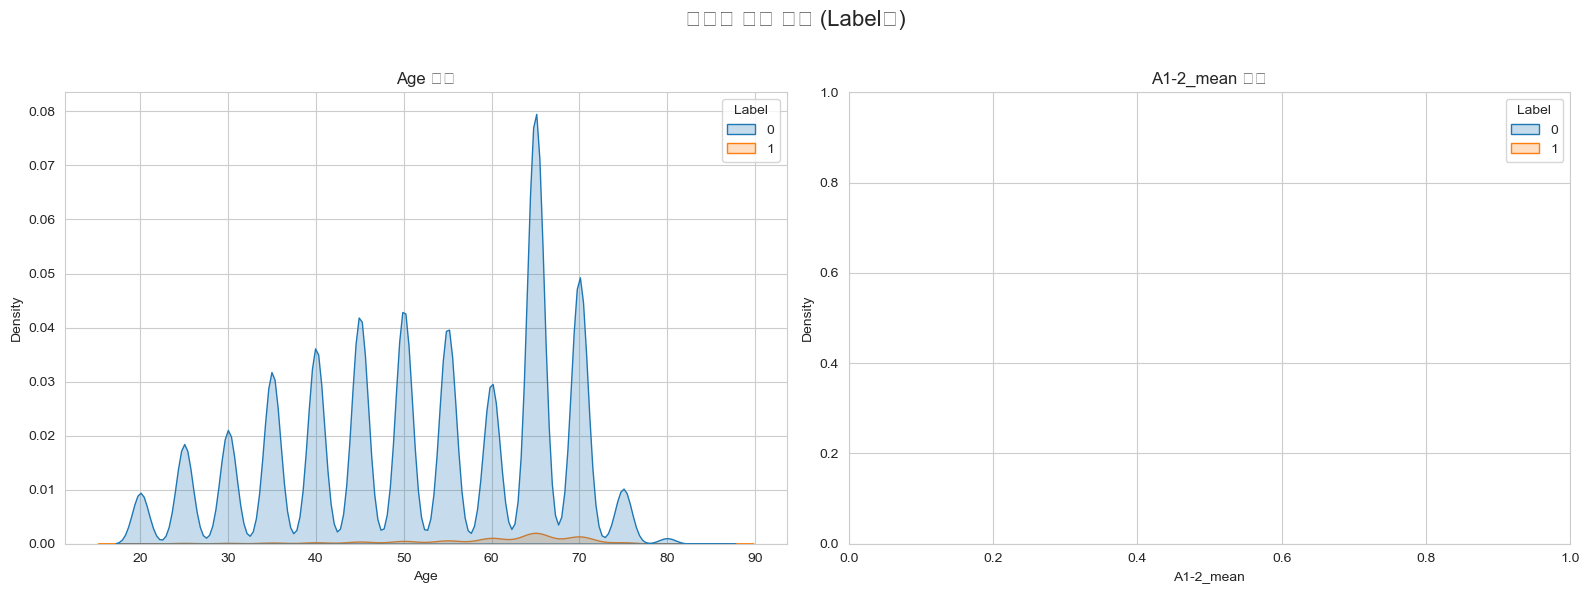

<Figure size 800x600 with 0 Axes>

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (필요 시)
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

sns.set_style('whitegrid')

if 'df_train_final' in globals():
    print("`df_train_final`을 사용하여 시각화를 시작합니다.")

    # 1. 시각화할 피처 선택 (예시)
    # 모델의 특성 중요도 등을 참고하여 주요 피처를 선택하는 것이 좋습니다.
    continuous_features = ['Age', 'A1-2_mean']
    categorical_features = ['Test']

    # 2. 연속형 피처 분포 시각화 (KDE Plot)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('연속형 피처 분포 (Label별)', fontsize=16)

    for i, feature in enumerate(continuous_features):
        if feature in df_train_final.columns:
            sns.kdeplot(data=df_train_final, x=feature, hue='Label', fill=True, ax=axes[i])
            axes[i].set_title(f'{feature} 분포')
        else:
            axes[i].set_title(f'{feature} not found')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 3. 범주형 피처 분포 시각화 (Count Plot)
    plt.figure(figsize=(8, 6))
    if 'Test' in df_train_final.columns:
        sns.countplot(data=df_train_final, x='Test', hue='Label')
        plt.title('Test(A/B) 그룹 별 Label 분포', fontsize=15)
    plt.show()

else:
    print("시각화를 위해 'df_train_final' 데이터프레임이 필요합니다. [1.6] 셀을 먼저 실행해주세요.")

### 피처 간 상관관계 히트맵

In [ ]:
if 'df_train_final' in globals():
    # 상관관계를 확인할 주요 숫자형 피처 선택 (너무 많으면 히트맵이 복잡해짐)
    corr_features = ['Label', 'Age'] + [col for col in df_train_final.columns if '_mean' in col][:5] + [col for col in df_train_final.columns if '_count' in col][:5]
    
    # 존재하는 컬럼만 필터링
    corr_features = [f for f in corr_features if f in df_train_final.columns]
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df_train_final[corr_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('주요 피처 간 상관관계 히트맵', fontsize=16)
    plt.show()


# 2. 모델 학습 (Model Training)

전처리된 데이터를 사용하여 LightGBM과 CatBoost 모델을 학습시키고, 학습된 모델을 파일로 저장합니다.

## 2.1. 라이브러리 설치 및 임포트

In [ ]:
!pip install lightgbm
!pip install catboost
!pip install optuna

In [24]:

import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss
import gc
import os
import optuna



## 2.2. LightGBM 모델 학습

In [25]:
# [2.2. LightGBM 모델 학습] - 셀 ID: a1d12894
# 이 셀의 코드를 아래 코드로 교체하세요.

## --- 2-1. 데이터 준비 확인 함수 ---
def check_data_ready():
    """
    1단계에서 생성된 'df_train_final' 변수가 메모리에 있는지 확인합니다.
    (노트북의 전역 변수 확인을 위해 'globals()' 사용)
    """
    print("--- 2단계: 모델 학습 시작 ---")
    
    if 'df_train_final' not in globals():
        print("!! 오류 !!: 1단계에서 생성된 'df_train_final' 변수를 찾을 수 없습니다.")
        print("1단계 코드를 먼저 실행하여 전처리를 완료해주세요.")
        # 오류를 발생시켜 이 셀의 실행을 중단시킴
        raise NameError("'df_train_final' not found. Please run Step 1 first.")
    
    # 데이터가 존재하면 Shape 정보 출력
    print(f"학습 데이터 df_train_final 로드 완료. Shape: {globals()['df_train_final'].shape}")

check_data_ready() 

# --- 2-2. 데이터를 '문제지(X)'와 '정답(y)'으로 분리 ---
y_target = df_train_final['Label']

# 'Test' 컬럼은 이제 특성(X)으로 사용해야 하므로 drop에서 제외
features_to_drop = ['Test_id', 'Label', 'PrimaryKey', 'TestDate'] 

# --- ★★★ 여기를 수정합니다 (Bug Fix) ★★★ ---
# 1. 먼저 drop 수행
X_features = df_train_final.drop(columns=features_to_drop)

# 2. (중요) 'Test' 컬럼의 타입을 'category'로 명시적 변환
if 'Test' in X_features.columns:
    # (★ .astype('category')가 category 타입이 아닌 컬럼을 처리하도록 수정)
    if not pd.api.types.is_categorical_dtype(X_features['Test']):
        X_features['Test'] = X_features['Test'].astype('category')
        print("✅ 'Test' 컬럼을 'category' 타입으로 강제 변환 완료.")
    else:
        print("✅ 'Test' 컬럼이 이미 'category' 타입입니다.")
else:
    print("!! 경고 !!: X_features에 'Test' 컬럼이 없습니다.")
# --- ★★★ 수정 끝 ★★★ ---

print(f"X (특성) Shape: {X_features.shape}")
print(f"y (타겟) Shape: {y_target.shape}")

# --- 2-3. 데이터를 훈련용(80%)과 검증용(20%)으로 분리 ---
X_train, X_val, y_train, y_val = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
)
print("훈련/검증 데이터 분리 완료.")

# --- 2-4. LightGBM 모델 설정 (★Optuna 최적 파라미터 적용★) ---
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=2000, 
    random_state=42,
    n_jobs=-1,
    boost_from_average=False,
    
    # ★★★ Optuna가 찾은 최적 파라미터 적용 ★★★
    learning_rate=0.02409214863359767, 
    max_depth=14, 
    num_leaves=46, 
    subsample=0.8458860961138605, 
    colsample_bytree=0.6211185848658003, 
    reg_alpha=0.6715665553249076, 
    reg_lambda=0.5655702803043035
)

# --- 2-5. 모델 학습 (fit) ---
print("\n모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)")
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['auc', 'binary_logloss'], 
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
               lgb.log_evaluation(period=100)],
    categorical_feature=['Test'] 
)

print("\n--- 모델 학습 완료 (최적 파라미터) ---")

# --- 2-6. 제출용 모델 파일 저장 ---
model_dir = 'submit/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model_path = os.path.join(model_dir, 'model.txt')
lgb_model.booster_.save_model(model_path)

print(f"모델이 '{model_path}' 경로에 성공적으로 저장되었습니다.")

# --- ★★★ 새로운 코드 시작 (모델 보정) ★★★ ---
# 1. 라이브러리 임포트
from sklearn.isotonic import IsotonicRegression
import joblib

print("\nLightGBM용 확률 교정기(IsotonicRegression)를 학습합니다...")

# 2. 검증 데이터의 원본(raw) 예측 확률 계산
val_preds_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

# 3. 교정기 생성 및 학습 (예측 확률 -> 실제 정답)
iso_reg_lgb = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
iso_reg_lgb.fit(val_preds_proba_lgb, y_val)

# 4. 교정기 모델 저장
calibrator_path_lgb = os.path.join(model_dir, 'calibrator_lgb.joblib')
joblib.dump(iso_reg_lgb, calibrator_path_lgb)

print(f"LGBM 교정기가 '{calibrator_path_lgb}' 경로에 저장되었습니다.")
# --- ★★★ 새로운 코드 끝 ★★★ ---


print("\n--- 2단계: 모델 학습 및 저장 완료 (최적 파라미터) ---")

--- 2단계: 모델 학습 시작 ---
학습 데이터 df_train_final 로드 완료. Shape: (944767, 290)


/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_1369/2322281344.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(X_features['Test']):


✅ 'Test' 컬럼이 이미 'category' 타입입니다.
X (특성) Shape: (944767, 286)
y (타겟) Shape: (944767,)
훈련/검증 데이터 분리 완료.

모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)
[LightGBM] [Info] Number of positive: 21826, number of negative: 733987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13589
[LightGBM] [Info] Number of data points in the train set: 755813, number of used features: 286
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.140345	valid_0's auc: 0.713639
[200]	valid_0's binary_logloss: 0.12018	valid_0's auc: 0.716789
[300]	valid_0's binary_logloss: 0.119664	valid_0's auc: 0.718185
[400]	valid_0's binary_logloss: 0.119626	valid_0's auc: 0.718286
[500]	valid_0's binary_logloss: 0.119598	valid_0's auc: 0.718629
[600]	valid_0's binary_logloss: 0.

# 3. 하이퍼파라미터 튜닝 (Hyperparameter Tuning with Optuna)

Optuna를 사용하여 대회 평가지표(Score)를 최소화하는 최적의 하이퍼파라미터를 탐색합니다. 이 단계에서 찾은 파라미터는 모델 학습 단계에 적용됩니다.

## 3.1. LightGBM 튜닝

In [ ]:


# 1. (필수) 변수 확인
if 'X_train' not in globals() or 'calculate_ece' not in globals():
    print("!! 오류 !!: [2단계]와 [3단계]를 먼저 실행하세요.")
    raise NameError("Prerequisites not found for Optuna.")

print("--- Optuna 하이퍼파라미터 튜닝 시작 (LGBM) ---")
print(f"목표: [Score]를 최소화하는 최적의 파라미터를 찾습니다.")

# 2. Optuna가 호출할 'objective' 함수 정의
def objective_lgb(trial):
    
    # 3. 튜닝할 하이퍼파라미터 탐색 공간 정의
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 2000, 
        'random_state': 42,
        'n_jobs': -1,
        'boost_from_average': False,
        # ★★★ 'scale_pos_weight' 제거 ★★★
        
        # --- Optuna 튜닝 대상 ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # 4. 모델 학습 (조기 종료 포함)
    model = lgb.LGBMClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['auc', 'binary_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        
        # ★★★ 'Test' 컬럼을 범주형으로 지정 ★★★
        categorical_feature=['Test']
    )
    
    # 5. 검증 데이터로 Score 계산
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, val_preds_proba)
    brier_score = brier_score_loss(y_val, val_preds_proba)
    ece_score = calculate_ece(y_val.values, val_preds_proba, n_bins=15)
    
    # 6. (핵심) 최종 Score 반환
    final_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score
    
    del model
    gc.collect()
    
    return final_score

# 7. Optuna 튜닝 실행
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True) # 30회 시도

# 8. 튜닝 결과 확인
print("\n--- Optuna 튜닝 완료 ---")
print(f"최고 Score (Best Value): {study_lgb.best_value:.6f}")
print("최적의 파라미터 (Best Params):")
print(study_lgb.best_params)

## 2.3. CatBoost 모델 학습

In [26]:
def check_model_prerequisites(model_name="Model"):
    """
    [2단계]에서 생성된 X_train, X_val 변수가 있는지 확인합니다.
    """
    print(f"--- {model_name} 모델 학습 시작 ---")
    
    if 'X_train' not in globals():
        print("!! 오류 !!: X_train, X_val 변수가 없습니다.")
        print("[2단계] LightGBM 셀을 먼저 실행하여 데이터를 분리해주세요.")
        raise NameError("X_train not found. Run Step 2 (LGBM) first.")
    
    print(f"{model_name} 학습용 데이터 확인 완료.")

### CatBoost 모델 학습 및 저장

In [27]:
# [2.3] CatBoost 모델 학습 - 셀 ID: 6750d699
# 이 셀의 코드를 아래 코드로 교체하세요.

from catboost import CatBoostClassifier
import os
import gc

# (이 셀 이전에 'check_model_prerequisites' 공용 함수가 정의되어 있어야 합니다)

# 1. 입력 데이터 검증 (공용 함수 사용)
check_model_prerequisites(model_name="CatBoost")

# 2. CatBoost 모델 설정 (★Optuna 최적 파라미터 적용★)
cat_model = CatBoostClassifier(
    objective='Logloss',
    eval_metric='AUC',
    iterations=2000, 
    random_seed=42,
    thread_count=-1,
    early_stopping_rounds=100,
    verbose=100,
    # task_type='GPU',
    
    # ★★★ Optuna가 찾은 최적 파라미터 적용 ★★★
    learning_rate=0.01078072468373634, 
    depth=8, 
    l2_leaf_reg=7.786054081505641, 
    border_count=44, 
    bagging_temperature=0.00020404891557600224
)

# 3. 모델 학습 (fit)
print("\nCatBoost 모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)")
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=['Test'] 
)

print("\n--- CatBoost 모델 학습 완료 (최적 파라미터) ---")

# 4. 제출용 모델 파일 저장
model_dir = 'submit/model'
model_path_cat = os.path.join(model_dir, 'model_cat.cbm')
cat_model.save_model(model_path_cat)

print(f"CatBoost 모델이 '{model_path_cat}' 경로에 성공적으로 저장되었습니다.")

# --- ★★★ 새로운 코드 시작 (모델 보정) ★★★ ---
# 1. 라이브러리 임포트 (LGBM 셀에서 이미 임포트했지만, 독립 실행을 위해 추가)
from sklearn.isotonic import IsotonicRegression
import joblib

print("\nCatBoost용 확률 교정기(IsotonicRegression)를 학습합니다...")

# 2. 검증 데이터의 원본(raw) 예측 확률 계산
val_preds_proba_cat = cat_model.predict_proba(X_val)[:, 1]

# 3. 교정기 생성 및 학습 (예측 확률 -> 실제 정답)
iso_reg_cat = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
iso_reg_cat.fit(val_preds_proba_cat, y_val)

# 4. 교정기 모델 저장
calibrator_path_cat = os.path.join(model_dir, 'calibrator_cat.joblib')
joblib.dump(iso_reg_cat, calibrator_path_cat)

print(f"CatBoost 교정기가 '{calibrator_path_cat}' 경로에 저장되었습니다.")
# --- ★★★ 새로운 코드 끝 ★★★ ---

print("\n--- 2-B단계: 모델 학습 및 저장 완료 (최적 파라미터) ---")

--- CatBoost 모델 학습 시작 ---
CatBoost 학습용 데이터 확인 완료.

CatBoost 모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)
0:	test: 0.5758549	best: 0.5758549 (0)	total: 125ms	remaining: 4m 10s
100:	test: 0.6989060	best: 0.6989060 (100)	total: 16.6s	remaining: 5m 11s
200:	test: 0.7071547	best: 0.7071547 (200)	total: 35.2s	remaining: 5m 15s
300:	test: 0.7117937	best: 0.7117937 (300)	total: 55.1s	remaining: 5m 10s
400:	test: 0.7143062	best: 0.7143062 (400)	total: 1m 13s	remaining: 4m 53s
500:	test: 0.7154802	best: 0.7154802 (500)	total: 1m 31s	remaining: 4m 33s
600:	test: 0.7161025	best: 0.7161025 (600)	total: 1m 48s	remaining: 4m 13s
700:	test: 0.7165659	best: 0.7165659 (700)	total: 2m 5s	remaining: 3m 52s
800:	test: 0.7168816	best: 0.7168877 (782)	total: 2m 21s	remaining: 3m 32s
900:	test: 0.7171940	best: 0.7171940 (900)	total: 2m 38s	remaining: 3m 12s
1000:	test: 0.7174686	best: 0.7174686 (1000)	total: 2m 54s	remaining: 2m 53s
1100:	test: 0.7177153	best: 0.7177153 (1100)	total: 3m 10s	remaining: 2m 3

## 3.2. CatBoost 튜닝

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
import gc

# 1. (필수) 필요한 변수 확인
if 'X_train' not in globals() or 'calculate_ece' not in globals():
    print("!! 오류 !!: [2단계]와 [3단계](ECE 함수 정의)를 먼저 실행하세요.")
    raise NameError("Prerequisites not found for Optuna.")

print("--- Optuna 하이퍼파라미터 튜닝 시작 (CatBoost) ---")
print(f"목표: [Score]를 최소화하는 최적의 파라미터를 찾습니다.")

# 2. Optuna가 호출할 'objective' 함수 정의
def objective_cat(trial):
    """
    Optuna 'trial'이 제안하는 파라미터로 CatBoost를 학습하고,
    '최종 Score'를 계산하여 반환합니다.
    """
    
    # 3. 튜닝할 하이퍼파라미터 탐색 공간 정의 (CatBoost용)
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': 2000, # (조기 종료로 자동 조절됨)
        'random_seed': 42,
        'thread_count': -1,
        'early_stopping_rounds': 100,
        'verbose': 0, # 튜닝 중 로그 끄기
        
        # --- Optuna 튜닝 대상 ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'depth': trial.suggest_int('depth', 6, 12), # CatBoost는 'max_depth' 대신 'depth'
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True), # L2 정규화
        'border_count': trial.suggest_int('border_count', 32, 255), # 분할 기준점 개수
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0), # 배깅 강도
        # 'scale_pos_weight'는 사용 안 함
    }

    # 4. 모델 학습 (조기 종료 포함)
    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=['Test'] # ★ 'Test' 범주형 지정
    )
    
    # 5. 검증 데이터로 Score 계산
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, val_preds_proba)
    brier_score = brier_score_loss(y_val, val_preds_proba)
    ece_score = calculate_ece(y_val.values, val_preds_proba, n_bins=15)
    
    # 6. (핵심) 최종 Score 반환
    final_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score
    
    del model
    gc.collect()
    
    return final_score

# 7. Optuna 튜닝 실행
study_cat = optuna.create_study(direction='minimize')

# n_trials 수를 조절하세요 (예: 15회)
study_cat.optimize(objective_cat, n_trials=15, show_progress_bar=True) 

# 8. 튜닝 결과 확인
print("\n--- Optuna 튜닝 완료 (CatBoost) ---")
print(f"최고 Score (Best Value): {study_cat.best_value:.6f}")
print("최적의 파라미터 (Best Params):")
print(study_cat.best_params)

# 4. 모델 평가 (Model Evaluation)

학습된 모델의 성능을 대회 평가지표(Score)와 AUC, Brier, ECE 등 다양한 지표를 통해 검증합니다. 또한, 앙상블 모델의 성능도 함께 평가합니다.

## 4.1. 평가 함수 정의

In [28]:
from sklearn.metrics import roc_auc_score, brier_score_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### ECE 및 성능 평가, 특성 중요도 시각화 함수

In [29]:
## --ECE 계산을 위한 헬퍼 함수

def calculate_ece(y_true, y_prob, n_bins=15):
    """
    Expected Calibration Error (ECE)를 계산합니다.
    """
    if y_prob.min() < 0 or y_prob.max() > 1:
        y_prob = np.clip(y_prob, 0, 1)

    bin_limits = np.linspace(0, 1, n_bins + 1)
    bin_limits[0] = -0.001 
    bin_limits[-1] = 1.001
    
    bin_indices = np.digitize(y_prob, bin_limits[1:-1])
    ece = 0.0
    total_samples = len(y_true)
    
    for i in range(n_bins):
        in_bin = (bin_indices == i)
        bin_size = np.sum(in_bin)
        if bin_size > 0:
            bin_accuracy = np.mean(y_true[in_bin])
            bin_confidence = np.mean(y_prob[in_bin])
            bin_weight = bin_size / total_samples
            ece += bin_weight * np.abs(bin_confidence - bin_accuracy)
    return ece


## -- 모델 성능 평가 함수
def evaluate_model(model, model_name):
    """
    학습된 모델을 받아 4가지 평가 지표(Score, AUC, Brier, ECE)를 계산하고 출력합니다.
    """
    print("\n" + "="*50)
    print(f" [ 🎯 {model_name} 모델 성능 평가]")
    print("="*50)

    # 1. 검증 데이터(X_val)로 예측 (1일 확률)
    # (y_val은 전역 변수로[2단계에서 생성] 사용)
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    
    # 2. 3가지 개별 지표 계산
    auc_score = roc_auc_score(y_val, val_preds_proba)
    brier_score = brier_score_loss(y_val, val_preds_proba)
    ece_score = calculate_ece(y_val.values, val_preds_proba, n_bins=15)
    
    # 3. 최종 평가 산식(Score) 계산
    final_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score
    
    # 4. 결과 출력
    print(f"  1. 최종 Score (0점 만점): {final_score:.6f} (낮을수록 좋음)")
    print("="*50)
    print(f"  2. AUC (Area Under Curve): {auc_score:.6f} (높을수록 좋음)")
    print(f"  3. Brier Score Loss: {brier_score:.6f} (낮을수록 좋음)")
    print(f"  4. ECE (Expected Calibration Error): {ece_score:.6f} (낮을수록 좋음)")
    print("="*50)

    
## -- 특성 중요도 시각화 함수
def plot_feature_importance(model, model_name, feature_names):
    """
    모델의 특성 중요도를 가져와 Top 30을 출력하고 시각화합니다.
    (LGBM, XGB, CatBoost를 모두 처리)
    """
    print(f"\n[ {model_name} 모델 Top 30 특성 중요도  ]")
    
    # 모델별로 특성 중요도를 가져오는 방식이 다름
    if model_name == 'CatBoost':
        importances = model.get_feature_importance()
    else: # LightGBM, XGBoost
        importances = model.feature_importances_
        
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    print(feature_importances.head(30))

    # 5. 특성 중요도 시각화
    plt.figure(figsize=(10, 12))
    sns.barplot(
        x=feature_importances.head(30).values, 
        y=feature_importances.head(30).index
    )
    plt.title(f"{model_name} - Top 30 Feature Importances", fontsize=15)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()



## 4.2. 개별 및 앙상블 모델 성능 평가


 [ 🎯 LightGBM 모델 성능 평가]
  1. 최종 Score (0점 만점): 0.147425 (낮을수록 좋음)
  2. AUC (Area Under Curve): 0.718866 (높을수록 좋음)
  3. Brier Score Loss: 0.026943 (낮을수록 좋음)
  4. ECE (Expected Calibration Error): 0.000488 (낮을수록 좋음)

[ LightGBM 모델 Top 30 특성 중요도  ]
PK_First_TestDate    1374
PK_Mean_Age          1222
PK_Last_TestDate     1059
PK_Test_Duration      992
TestDate_Year         515
A3-7_std              453
A3-4_std              442
A2-4_mean             436
PK_A_Test_Count       435
Age                   434
A4-5_max              427
A4-5_std              426
A1-4_min              420
A2-4_std              404
A9-5                  393
A2-4_median           390
PK_B_Test_Count       382
A1-4_median           381
A1-4_max              378
A9-4                  371
A2-4_min              369
A1-4_std              360
A3-7_median           359
B4-2_std              353
TestDate_Month        353
PK_Test_Count         344
B3-2_min              336
B5-2_min              332
B5-2_std              331

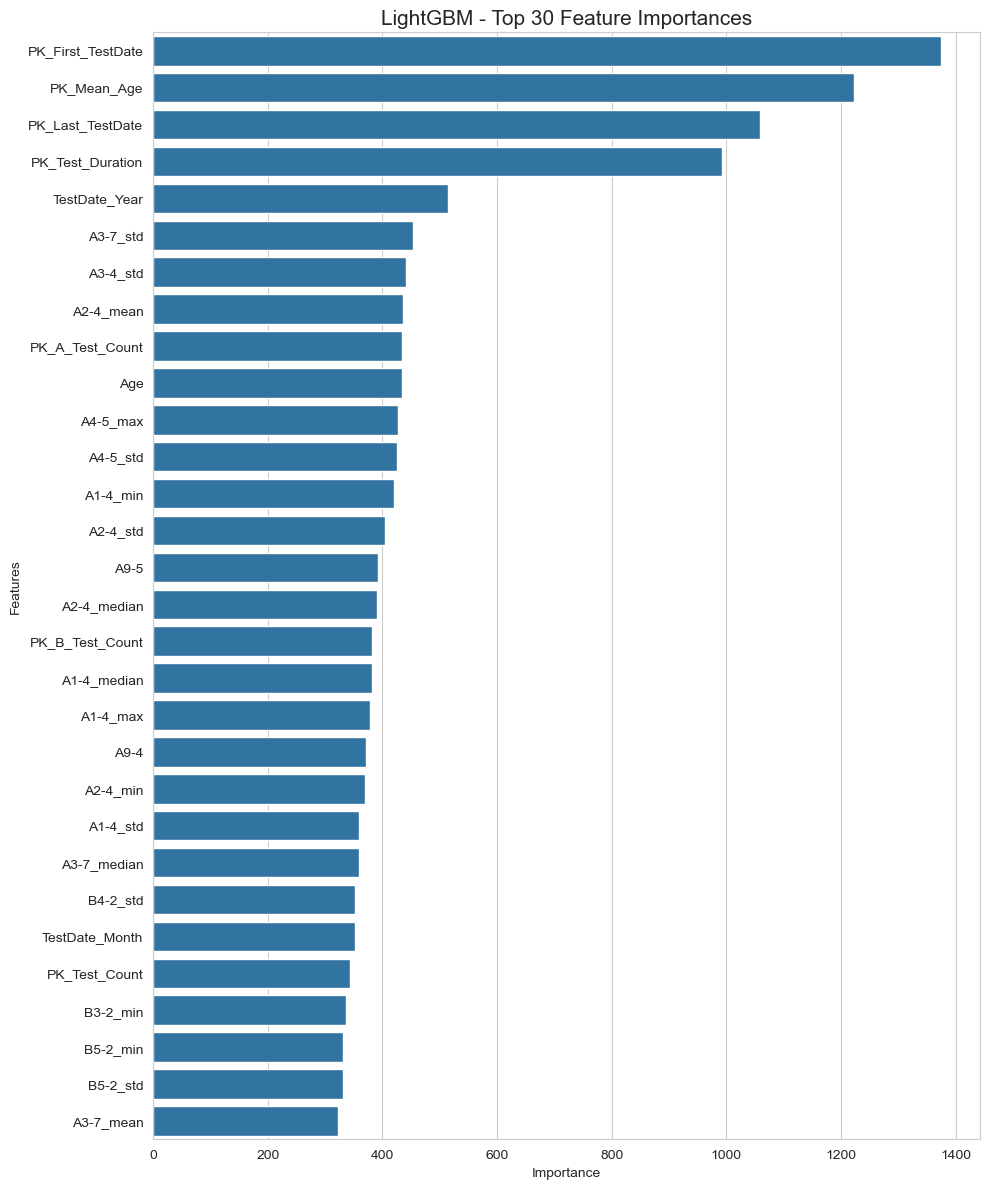


 [ 🎯 CatBoost 모델 성능 평가]
  1. 최종 Score (0점 만점): 0.147401 (낮을수록 좋음)
  2. AUC (Area Under Curve): 0.718938 (높을수록 좋음)
  3. Brier Score Loss: 0.026924 (낮을수록 좋음)
  4. ECE (Expected Calibration Error): 0.000556 (낮을수록 좋음)

[ CatBoost 모델 Top 30 특성 중요도  ]
PK_A_Test_Count      12.393796
PK_Test_Duration      7.993554
TestDate_Year         5.343047
PK_First_TestDate     5.261753
PK_Mean_Age           4.898225
PK_Max_Age            4.011671
PK_Age_Range          3.995158
PK_Min_Age            3.583507
PK_Test_Count         3.554023
PK_B_Test_Count       3.209388
Age                   2.948935
PK_Last_TestDate      2.310990
A9-5                  1.679192
TestDate_Month        1.114369
A9-4                  1.057264
A3-5_std              0.860306
B4-1_mean             0.784402
A6-1                  0.775534
A1-4_min              0.756763
A3-7_mean             0.744017
A3-4_std              0.647683
A3-7_max              0.631092
B9-5                  0.616906
A4-5_median           0.614626
B3-2_medi

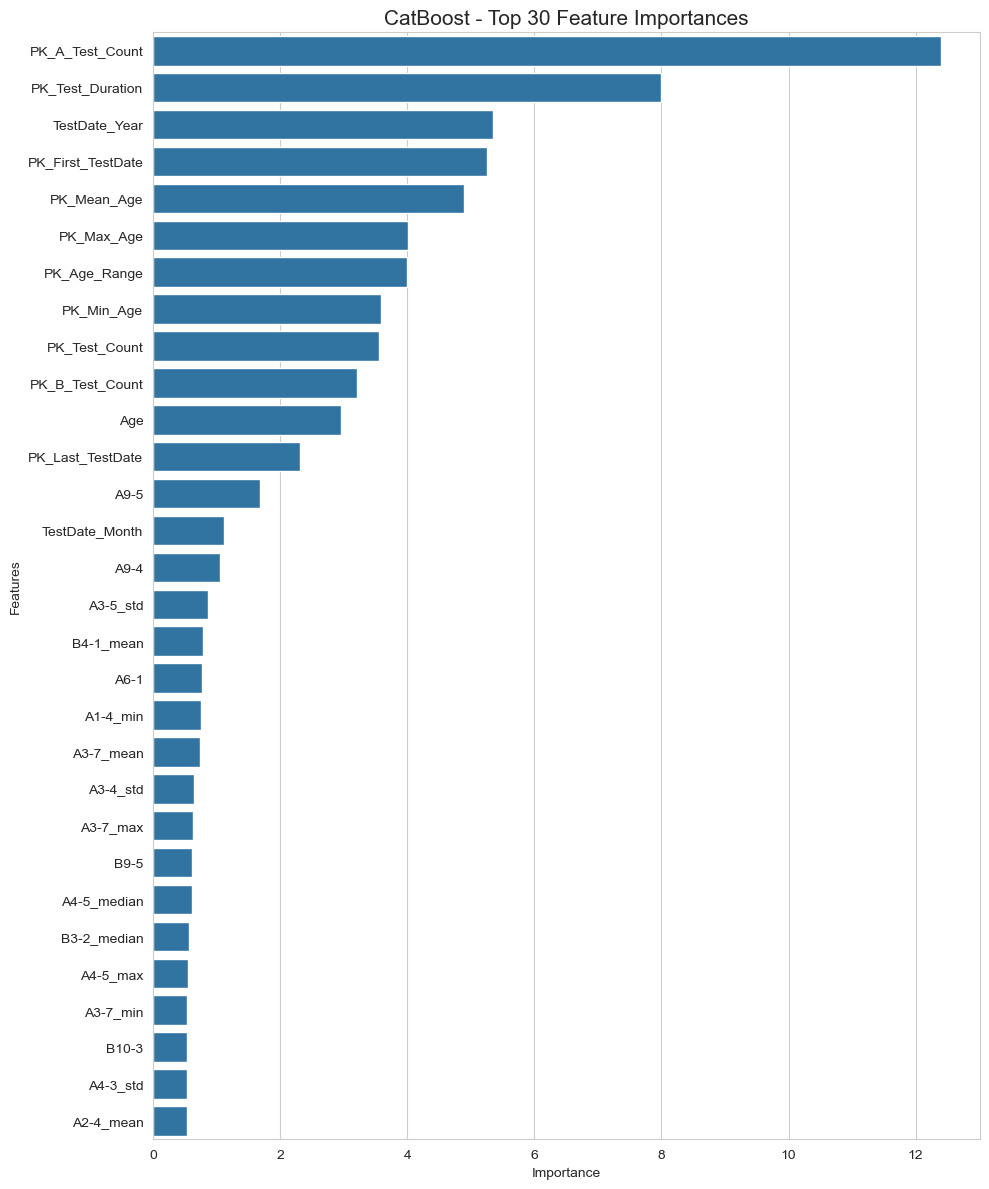


--- 3단계: 모델 평가 완료 ---


In [31]:

# 1. [2단계]에서 생성된 변수들이 있는지 확인
if 'X_val' not in globals() or 'y_val' not in globals():
    print("!! 오류 !!: 'X_val' 또는 'y_val' 변수를 찾을 수 없습니다.")
    print("[2단계] 코드를 먼저 실행해주세요.")
    raise NameError("X_val or y_val not found. Run Step 2 first.")
else:
    # 2. 학습된 각 모델에 대해 평가 함수 실행
    
    # (X_train.columns는 [2단계]에서 생성된 전역 변수)
    feature_names = X_train.columns
    
    # -- LightGBM 평가 --
    if 'lgb_model' in globals():
        evaluate_model(lgb_model, "LightGBM")
        plot_feature_importance(lgb_model, "LightGBM", feature_names)
    else:
        print("\n[알림] 'lgb_model'이 학습되지 않아 평가를 건너뜁니다.")
        
    # -- CatBoost 평가 --
    if 'cat_model' in globals():
        evaluate_model(cat_model, "CatBoost")
        plot_feature_importance(cat_model, "CatBoost", feature_names)
    else:
        print("\n[알림] 'cat_model'이 학습되지 않아 평가를 건너뜁니다.")

    print("\n--- 3단계: 모델 평가 완료 ---")

In [38]:
# [4.2] 앙상블 모델 성능 평가 - 셀 ID: 698cae1c
# 이 셀의 코드를 아래 코드로 교체하세요.

### 앙상블(Ensemble) 모델 성능 평가 (★ 스태킹으로 변경 ★) ###
from sklearn.linear_model import LogisticRegression
import numpy as np
import joblib
import os

# --- [함수 정의] 앙상블 준비물 확인 ---
def check_prerequisites_ensemble():
    """ 앙상블에 필요한 모델과 함수가 준비되었는지 확인합니다. """
    print("--- 앙상블(Ensemble) 모델 성능 평가 시작 (★ 스태킹 ★) ---")

    if 'lgb_model' not in globals() or 'iso_reg_lgb' not in globals():
        raise NameError("lgb_model 또는 iso_reg_lgb가 학습되지 않았습니다. [2.2]를 실행하세요.")
    if 'cat_model' not in globals() or 'iso_reg_cat' not in globals():
        raise NameError("cat_model 또는 iso_reg_cat가 학습되지 않았습니다. [2.3]을 실행하세요.")
    if 'calculate_ece' not in globals():
        raise NameError("'calculate_ece' 함수가 없습니다. [4.1]을 먼저 실행하세요.")
    
    print("스태킹에 필요한 모델(LGBM, CatBoost)과 교정기(Isotonic) 확인 완료.")

# -------------------------------------------------
# [메인 로직]
# -------------------------------------------------

# 1. 앙상블 준비물 검증
try:
    check_prerequisites_ensemble()

    # 2. 각 모델의 (원본) 검증 데이터 예측 확률 가져오기
    print("각 모델의 (원본) 예측 확률을 계산합니다...")
    lgb_preds_proba = lgb_model.predict_proba(X_val)[:, 1]
    cat_preds_proba = cat_model.predict_proba(X_val)[:, 1]

    # 3. 교정기를 사용하여 예측 확률 보정
    print("교정기(IsotonicRegression)를 적용하여 확률을 보정합니다...")
    lgb_preds_calibrated = iso_reg_lgb.predict(lgb_preds_proba)
    cat_preds_calibrated = iso_reg_cat.predict(cat_preds_proba)
    
    # --- ★★★ 여기부터 스태킹 로직 ★★★ ---
    
    # 4. (신규) 2차 모델(Meta-Model) 학습
    print("2차 모델(LogisticRegression)을 학습합니다...")
    
    # 4-1. 메타 모델의 '입력(X)' 준비 (보정된 예측값 2개를 피처로 사용)
    X_meta_train = np.column_stack((lgb_preds_calibrated, cat_preds_calibrated))
    
    # 4-2. 메타 모델의 '정답(y)' 준비 (원본 검증 데이터의 라벨)
    y_meta_train = y_val
    
    # 4-3. 메타 모델 생성 및 학습
    meta_model = LogisticRegression(C=1.0, random_state=42) # C=1.0은 기본값
    meta_model.fit(X_meta_train, y_meta_train)
    
    print("2차 모델 학습 완료.")
    
    # 5. (신규) 2차 모델(Meta-Model) 저장
    model_dir = 'submit/model'
    meta_model_path = os.path.join(model_dir, 'meta_model.joblib')
    joblib.dump(meta_model, meta_model_path)
    print(f"2차 모델(Meta-Model)이 '{meta_model_path}' 경로에 저장되었습니다.")

    # 6. (수정) *스태킹* 앙상블 모델 성능 평가
    # 메타 모델을 사용하여 최종 예측 확률 생성
    ensemble_preds_proba = meta_model.predict_proba(X_meta_train)[:, 1]
    print("스태킹 앙상블 예측 완료.")
    
    # --- ★★★ 스태킹 로직 끝 ★★★ ---

    auc_score_ens = roc_auc_score(y_val, ensemble_preds_proba)
    brier_score_ens = brier_score_loss(y_val, ensemble_preds_proba)
    ece_score_ens = calculate_ece(y_val.values, ensemble_preds_proba, n_bins=15)
    final_score_ens = 0.5 * (1 - auc_score_ens) + 0.25 * brier_score_ens + 0.25 * ece_score_ens

except NameError as e:
    print(f"\n!! 앙상블 평가 실패: {e}")
    final_score_ens = -1 # 에러 플래그

if final_score_ens != -1:
    print(f"\n[ 🚀 앙상블 모델 최종 성능 평가 (★스태킹 적용★) 🚀 ]")
    print("="*40)
    print(f"  1. 🏆 앙상블 최종 Score: {final_score_ens:.6f} (낮을수록 좋음)")
    print("="*40)
    print(f"  2. 앙상블 AUC: {auc_score_ens:.6f}")
    print(f"  3. 앙상블 Brier: {brier_score_ens:.6f}")
    print(f"  4. 앙상블 ECE: {ece_score_ens:.6f}")
    print("="*40)
    print(f"\n(단순 평균 앙상블 Score 보다 개선되었는지 확인해보세요.)")

--- 앙상블(Ensemble) 모델 성능 평가 시작 (★ 스태킹 ★) ---
스태킹에 필요한 모델(LGBM, CatBoost)과 교정기(Isotonic) 확인 완료.
각 모델의 (원본) 예측 확률을 계산합니다...
교정기(IsotonicRegression)를 적용하여 확률을 보정합니다...
2차 모델(LogisticRegression)을 학습합니다...
2차 모델 학습 완료.
2차 모델(Meta-Model)이 'submit/model/meta_model.joblib' 경로에 저장되었습니다.
스태킹 앙상블 예측 완료.

[ 🚀 앙상블 모델 최종 성능 평가 (★스태킹 적용★) 🚀 ]
  1. 🏆 앙상블 최종 Score: 0.146565 (낮을수록 좋음)
  2. 앙상블 AUC: 0.721443
  3. 앙상블 Brier: 0.027122
  4. 앙상블 ECE: 0.002024

(단순 평균 앙상블 Score 보다 개선되었는지 확인해보세요.)


# 5. 제출 (Submission)

대회 제출을 위해 `requirements.txt`, `script.py`, `model.txt`, `model_cat.cbm` 파일을 `submit` 폴더에 생성하고, 최종적으로 `submit.zip` 압축 파일을 만듭니다.

## 5.1. `requirements.txt` 파일 생성

In [33]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cat
import sklearn
import os

# (submit 폴더 생성)
submit_dir = 'submit'
if not os.path.exists(submit_dir):
    os.makedirs(submit_dir)

required_libs = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "lightgbm": lgb.__version__,
    "catboost": cat.__version__,
    "scikit-learn": sklearn.__version__
}

req_path = os.path.join(submit_dir, 'requirements.txt')

try:
    with open(req_path, 'w') as f:
        for lib, version in required_libs.items():
            f.write(f"{lib}=={version}\n")
    print(f"'{req_path}' 파일이 성공적으로 생성되었습니다.")
    print("--- 파일 내용 ---")
    with open(req_path, 'r') as f:
        print(f.read())

except Exception as e:
    print(f"requirements.txt 파일 생성 중 오류 발생: {e}")

'submit/requirements.txt' 파일이 성공적으로 생성되었습니다.
--- 파일 내용 ---
pandas==2.2.3
numpy==2.1.3
lightgbm==4.6.0
catboost==1.2.8
scikit-learn==1.6.1



## 5.2. `script.py` 파일 생성

In [ ]:
# [5.2] script.py 파일 생성 - 셀 ID: 45b00a64
# 이 셀의 코드를 아래 코드로 교체하세요.

import os

SCRIPT_CONTENT = """
import pandas as pd
import numpy as np
import re
import glob
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool 
import gc
import os
import joblib  # ★ 1. joblib 임포트

# --- 1. 전처리 함수 정의 ---
def preprocess_age(age_str):
    ''' '40b', '60a' 같은 나이 문자열을 숫자로 변환합니다. '''
    if pd.isna(age_str): return np.nan
    try:
        base_age = int(re.findall(r'^\\d+', age_str)[0])
        if 'a' in age_str: return base_age
        elif 'b' in age_str: return base_age + 5
    except: return np.nan

# ★ (중요) script.py의 전처리 함수도 개선된 버전으로 교체합니다 ★
def get_string_list_stats(series, col_name):
    '''
    [개선된 버전]
    쉼표로 구분된 숫자 문자열 리스트(Series)를 받아
    통계 특성(평균, 표준편차, min, max, 중앙값, 개수)을 효율적으로 계산합니다.
    '''
    
    def calculate_stats_for_row(s):
        ''' 하나의 문자열(행)을 받아 모든 통계치를 담은 Series를 반환합니다. '''
        if pd.isna(s):
            # 빈 행에 대한 기본값 (7개 통계치)
            return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, 0, 0])

        num_list = [pd.to_numeric(x, errors='coerce') for x in str(s).split(',')]
        
        # np.nan* 함수들은 NaN을 무시하고 계산
        mean_val = np.nanmean(num_list)
        std_val = np.nanstd(num_list)
        min_val = np.nanmin(num_list)
        max_val = np.nanmax(num_list)
        median_val = np.nanmedian(num_list)
        
        count_val = len(num_list)
        nan_count_val = pd.Series(num_list).isna().sum()
        
        return pd.Series([mean_val, std_val, min_val, max_val, median_val, count_val, nan_count_val])

    stat_names = ['mean', 'std', 'min', 'max', 'median', 'count', 'nan_count']
    col_names = [f'{col_name}_{stat}' for stat in stat_names]
    
    df_stats = series.apply(calculate_stats_for_row)
    df_stats.columns = col_names
    
    # astype(np.float32) 추가 (메모리 효율)
    return df_stats.astype(np.float32)

def process_dataframe(df, file_type='A'):
    ''' DataFrame(청크)을 받아 전처리 및 특성 공학을 수행합니다. '''
    
    # ★ 1-1. TestDate 피처 엔지니어링 추가 (1순위 전략 반영) ★
    processed_cols = ['Test_id', 'PrimaryKey', 'TestDate']
    valid_cols = [col for col in processed_cols if col in df.columns]
    df_processed = df[valid_cols].copy()

    if 'Age' in df.columns: 
        df_processed['Age'] = df['Age'].apply(preprocess_age)
    
    if 'TestDate' in df.columns:
        test_date_str = df['TestDate'].astype(str)
        df_processed['TestDate_Year'] = pd.to_numeric(test_date_str.str[:4], errors='coerce')
        df_processed['TestDate_Month'] = pd.to_numeric(test_date_str.str[4:], errors='coerce')

    # ( ... 기존 A/B 컬럼 정의 ... )
    if file_type == 'A':
        numeric_cols = [f'A6-1', 'A7-1', 'A8-1', 'A8-2'] + [f'A9-{i}' for i in range(1, 6)]
        string_cols = [f'A{i}-{j}' for i in range(1, 6) for j in range(1, 8) if f'A{i}-{j}' not in numeric_cols and f'A{i}-{j}' in df.columns]
    elif file_type == 'B':
        numeric_cols = [f'B9-{i}' for i in range(1, 6)] + [f'B10-{i}' for i in range(1, 7)]
        string_cols = [f'B{i}-{j}' for i in range(1, 9) for j in range(1, 3) if f'B{i}-{j}' in df.columns]
        string_cols += ['B6', 'B7', 'B8']
    else: return pd.DataFrame()
    
    for col in numeric_cols:
        if col in df.columns: df_processed[col] = pd.to_numeric(df[col], errors='coerce')
    
    # ( tqdm은 submission 스크립트에서 제거 )
    for col in string_cols:
        if col in df.columns:
            stats_df = get_string_list_stats(df[col], col)
            df_processed = pd.concat([df_processed, stats_df], axis=1)
            
    return df_processed
# --- (전처리 함수 정의 끝) ---

# --- 2. 추론(Inference) 실행 ---
def main():
    print("[+] Inference script started.")
    DATA_DIR, MODEL_DIR, OUTPUT_DIR = './data', './model', './output'
    TEST_A_PATH = os.path.join(DATA_DIR, 'test', 'A.csv')
    TEST_B_PATH = os.path.join(DATA_DIR, 'test', 'B.csv')
    TEST_IDS_PATH = os.path.join(DATA_DIR, 'test.csv')
    SUBMISSION_PATH = os.path.join(OUTPUT_DIR, 'submission.csv')
    CHUNKSIZE = 100000

    # ★ 2. 모델 및 교정기 경로 정의 ★
    LGB_MODEL_PATH = os.path.join(MODEL_DIR, 'model.txt')
    CAT_MODEL_PATH = os.path.join(MODEL_DIR, 'model_cat.cbm')
    LGB_CALIBRATOR_PATH = os.path.join(MODEL_DIR, 'calibrator_lgb.joblib')
    CAT_CALIBRATOR_PATH = os.path.join(MODEL_DIR, 'calibrator_cat.joblib')

    # ★ 3. 모델 및 교정기 로드 ★
    try:
        lgb_model = lgb.Booster(model_file=LGB_MODEL_PATH)
        lgb_features = lgb_model.feature_name()
        print(f"LGBM Model loaded from {LGB_MODEL_PATH}")
        
        cat_model = CatBoostClassifier()
        cat_model.load_model(CAT_MODEL_PATH)
        cat_features_model = cat_model.feature_names_ 
        print(f"CatBoost Model loaded from {CAT_MODEL_PATH}")
        
        lgb_calibrator = joblib.load(LGB_CALIBRATOR_PATH)
        print(f"LGBM Calibrator loaded from {LGB_CALIBRATOR_PATH}")
        cat_calibrator = joblib.load(CAT_CALIBRATOR_PATH)
        print(f"CatBoost Calibrator loaded from {CAT_CALIBRATOR_PATH}")
        
    except Exception as e:
        print(f"!! Error loading models or calibrators: {e}"); return

    # 4. 테스트 데이터 전처리 (A, B)
    print("Processing Test A file...")
    processed_chunks_A = []
    try:
        with pd.read_csv(TEST_A_PATH, chunksize=CHUNKSIZE) as reader:
            for chunk in reader: processed_chunks_A.append(process_dataframe(chunk, file_type='A')); gc.collect()
    except FileNotFoundError: print("Test A file not found. Skipping.")
    print("Processing Test B file...")
    processed_chunks_B = []
    try:
        with pd.read_csv(TEST_B_PATH, chunksize=CHUNKSIZE) as reader:
            for chunk in reader: processed_chunks_B.append(process_dataframe(chunk, file_type='B')); gc.collect()
    except FileNotFoundError: print("Test B file not found. Skipping.")

    df_A_processed = pd.concat(processed_chunks_A, ignore_index=True) if processed_chunks_A else pd.DataFrame()
    df_B_processed = pd.concat(processed_chunks_B, ignore_index=True) if processed_chunks_B else pd.DataFrame()
    df_all_features = pd.concat([df_A_processed, df_B_processed], ignore_index=True, sort=False)
    print(f"Total processed test features shape: {df_all_features.shape}")

    # 5. `test.csv`의 ID 및 'Test' 컬럼과 병합
    try:
        df_test_meta = pd.read_csv(TEST_IDS_PATH)[['Test_id', 'Test']]
        df_test_final = pd.merge(df_test_meta, df_all_features, on='Test_id', how='left')
        
        # ★ 1순위 전략(PrimaryKey)을 위한 피처 엔지니어링 추가 ★
        print("Creating PrimaryKey-based features for test set...")
        df_test_final['TestDate_Numeric'] = pd.to_datetime(df_test_final['TestDate'], format='%Y%m', errors='coerce')
        df_test_final['TestDate_Numeric'] = df_test_final['TestDate_Numeric'].dt.year + \
                                            (df_test_final['TestDate_Numeric'].dt.month / 12.0)
        df_test_final['TestDate_Numeric'] = df_test_final['TestDate_Numeric'].fillna(0)
        
        grouped_by_pk = df_test_final.groupby('PrimaryKey')
        pk_features = grouped_by_pk.agg(
            PK_Test_Count=('Test_id', 'count'), PK_First_TestDate=('TestDate_Numeric', 'min'),
            PK_Last_TestDate=('TestDate_Numeric', 'max'), PK_Mean_Age=('Age', 'mean'),
            PK_Min_Age=('Age', 'min'), PK_Max_Age=('Age', 'max')
        ).reset_index()
        pk_features['PK_First_TestDate'].replace(0, np.nan, inplace=True)
        pk_features['PK_Last_TestDate'].replace(0, np.nan, inplace=True)
        pk_features['PK_Test_Duration'] = pk_features['PK_Last_TestDate'] - pk_features['PK_First_TestDate']
        pk_features['PK_Age_Range'] = pk_features['PK_Max_Age'] - pk_features['PK_Min_Age']
        
        # (★ .astype(str) 추가)
        pk_test_type_counts = df_test_final.groupby(['PrimaryKey', df_test_final['Test'].astype(str)]).size().unstack(fill_value=0)
        pk_test_type_counts.columns = [f'PK_{col}_Test_Count' for col in pk_test_type_counts.columns]
        pk_test_type_counts = pk_test_type_counts.reset_index()

        df_test_final = pd.merge(df_test_final, pk_features, on='PrimaryKey', how='left')
        df_test_final = pd.merge(df_test_final, pk_test_type_counts, on='PrimaryKey', how='left')
        df_test_final = df_test_final.drop(columns=['TestDate_Numeric'])
        print("PrimaryKey features merged for test set.")
        
        # 'Test' 컬럼 타입 설정 (CatBoost Pool용)
        df_test_final['Test'] = df_test_final['Test'].astype(str) 
        print("Merged with test.csv successfully.")
    except Exception as e:
        print(f"Error loading/merging test.csv or creating PK features: {e}"); return

    # 6. 예측을 위한 특성 준비 (모델별로)
    
    # 6-1. LightGBM용 X_test
    # (★ 1순위 전략 반영: lgb_features에 없는 새 피처가 있어도 reindex로 자동 처리됨)
    X_test_lgb = df_test_final.reindex(columns=lgb_features, fill_value=np.nan)
    if 'Test' in X_test_lgb.columns:
        X_test_lgb['Test'] = X_test_lgb['Test'].astype('category')
    print(f"Final X_test_lgb shape for prediction: {X_test_lgb.shape}")

    # 6-2. CatBoost용 Pool
    # (★ 1순위 전략 반영: cat_features_model에 없는 새 피처는 자동으로 무시됨)
    final_cat_features = [col for col in cat_features_model if col in df_test_final.columns]
    X_test_cat_df = df_test_final[final_cat_features]
    
    categorical_features_indices = [i for i, col in enumerate(X_test_cat_df.columns) if col == 'Test']
    print(f"Categorical feature index for CatBoost Pool: {categorical_features_indices}")

    test_pool = Pool(data=X_test_cat_df, cat_features=categorical_features_indices)
    print(f"CatBoost Pool created successfully.")

    # ★ 7. 앙상블 예측 수행 (보정 단계 추가) ★
    print("Predicting probabilities (LGBM - Raw)...")
    preds_lgb_raw = lgb_model.predict(X_test_lgb)
    
    print("Predicting probabilities (CatBoost - Raw)...")
    preds_cat_raw = cat_model.predict_proba(test_pool)[:, 1]
    
    print("Applying calibration (IsotonicRegression)...")
    preds_lgb = lgb_calibrator.predict(preds_lgb_raw)
    preds_cat = cat_calibrator.predict(preds_cat_raw)

    print("Averaging calibrated predictions (Ensemble)...")
    final_predictions = (preds_lgb + preds_cat) / 2.0
    
    # 8. 제출 파일 생성
    df_submission = pd.DataFrame({
        'Test_id': df_test_final['Test_id'],
        'Label': final_predictions
    })
    
    # 9. 결과 저장
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    df_submission.to_csv(SUBMISSION_PATH, index=False)
    
    print(f"[+] Submission file saved to {SUBMISSION_PATH}")
    print("[+] Inference script finished.")

if __name__ == "__main__":
    main()
"""

# 'submit' 폴더 안에 'script.py' 파일로 저장
script_path = os.path.join('submit', 'script.py')
try:
    with open(script_path, 'w', encoding='utf-8') as f:
        f.write(SCRIPT_CONTENT)
    print(f"'{script_path}' 파일이 성공적으로 생성되었습니다.")
except Exception as e:
    print(f"script.py 파일 생성 중 오류 발생: {e}")

'submit/script.py' 파일이 성공적으로 생성되었습니다.


## 5.3. `submit.zip` 파일 생성

In [35]:
import shutil

print("--- 4단계 (C): 'submit.zip' 파일 생성 시작 ---")

folder_to_zip = 'submit'
zip_filename = 'submit'

try:
    shutil.make_archive(
        base_name=zip_filename,
        format='zip',
        root_dir='.',
        base_dir=folder_to_zip
    )
    print(f"\n✅ '{folder_to_zip}' 폴더가 '{zip_filename}.zip' 파일로 성공적으로 압축되었습니다.")
    print("이 'submit.zip' 파일을 대회에 제출하시면 됩니다.")

except Exception as e:
    print(f"\n!! 오류 !!: 'submit.zip' 파일 압축 중 오류가 발생했습니다: {e}")

--- 4단계 (C): 'submit.zip' 파일 생성 시작 ---

✅ 'submit' 폴더가 'submit.zip' 파일로 성공적으로 압축되었습니다.
이 'submit.zip' 파일을 대회에 제출하시면 됩니다.
